In [10]:
# %run 00-start-eva-server.ipynb
cursor = connect_to_server()

You should consider upgrading via the '/Users/jiashenc/Workspace/eva/evadb_venv/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [11]:
# Load all images
cursor.execute("LOAD IMAGE 'reddit-images/*.jpg' INTO reddit_dataset")
response = cursor.fetch_all()
print(response)
cursor.execute("LOAD IMAGE 'reddit-images/*.png' INTO reddit_dataset")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                             0
0  Number of loaded IMAGE: 18
@query_time: 0.1875054580000004
@status: ResponseStatus.SUCCESS
@batch: 
                             0
0  Number of loaded IMAGE: 11
@query_time: 0.15624599999999944


In [12]:
# Keep track of which image gets the most votes
from collections import Counter
vote = Counter()

In [13]:
"""
Image-level similarity search pipeline. This pipeline creates one vector per image.
Next, we should breakdown steps how we build the index and search similar vectors 
using the index.
"""

'\nImage-level similarity search pipeline. This pipeline creates one vector per image.\nNext, we should breakdown steps how we build the index and search similar vectors \nusing the index.\n'

In [14]:
#1. Create index for the entire image
cursor.execute("""CREATE INDEX reddit_sift_image_index 
                    ON reddit_dataset (SiftFeatureExtractor(data)) 
                    USING HNSW""")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                                                    0
0  Index reddit_sift_image_index successfully added to the database.
@query_time: 0.5421173330000038


In [15]:
#2. Search similar vectors
cursor.execute("""SELECT name FROM reddit_dataset ORDER BY
                    Similarity(
                      SiftFeatureExtractor(Open('reddit-images/search.jpg')),
                      SiftFeatureExtractor(data)
                    )
                    LIMIT 5""")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                reddit_dataset.name
0         reddit-images/search.jpg
1  reddit-images/g1190_cln97xm.jpg
2  reddit-images/g1190_clndsnu.png
3  reddit-images/g1190_clnc4uy.png
4  reddit-images/g1190_clncot0.jpg
@query_time: 0.3379026249999981


In [17]:
#3. Update votes
res_df = response.as_df()
for i in range(len(res_df)):
    vote[res_df["reddit_dataset.name"][i]] += 1
print(vote)

Counter({'reddit-images/search.jpg': 1, 'reddit-images/g1190_cln97xm.jpg': 1, 'reddit-images/g1190_clndsnu.png': 1, 'reddit-images/g1190_clnc4uy.png': 1, 'reddit-images/g1190_clncot0.jpg': 1})


In [34]:
"""
Object-level similarity search pipeline. This pipeline detects existing object per
image and then create a vector only from the cropped object. Index is then built on
top of vectors for objects. 
"""

'\nObject-level similarity search pipeline. This pipeline detects existing object per\nimage and then create a vector only from the cropped object. Index is then built on\ntop of vectors for objects. \n'

In [35]:
#1. Create a secondary table that contains object.
cursor.execute("""CREATE MATERIALIZED VIEW reddit_object_dataset (name, data, bboxes, labels)
                    AS SELECT name, data, bboxes, labels FROM reddit_dataset
                      JOIN LATERAL UNNEST(YoloV5(data)) AS Obj(labels, bboxes, scores)""")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
 Empty DataFrame
Columns: []
Index: []
@query_time: 3.560544416999619


In [37]:
#2. Create index from objects
cursor.execute("""CREATE INDEX reddit_sift_object_index
                    ON reddit_object_dataset (SiftFeatureExtractor(Crop(data, bboxes)))
                    USING HNSW""")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                                                     0
0  Index reddit_sift_object_index successfully added to the database.
@query_time: 0.28588608399968507


In [ ]:
#3. Search index: TODO

libpng warning: iCCP: known incorrect sRGB profile


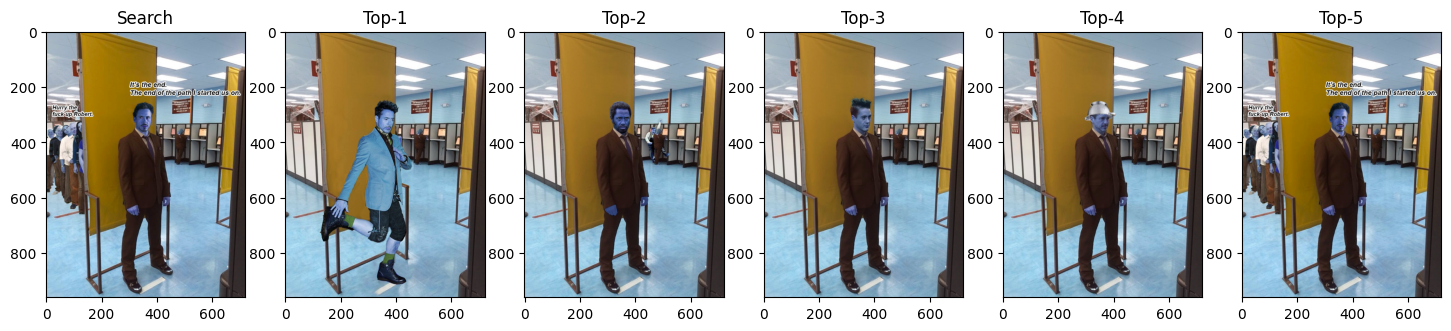

In [33]:
# !pip install matplotlib
import cv2
import matplotlib.pyplot as plt

# Display top images
vote_list = list(reversed(sorted([(path, count) for path, count in vote.items()], key=lambda x: x[1])))
img_list = [path for path, _ in vote_list]

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=[18,10])
ax[0].imshow(cv2.imread("../reddit-images/search.jpg"))
ax[0].set_title("Search")

for i in range(5):
    axi = ax[i + 1]
    img = cv2.imread("../" + img_list[i])
    axi.imshow(img)
    axi.set_title(f"Top-{i + 1}")

plt.show()